In [17]:
%matplotlib inline



# Evaluating Performance
Once we have a quantified measure of the quality of a given fitted gridder, we can use it to tune the
gridder's parameters, like ``damping`` and ``mindist``.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj
import verde as vd

data = vd.datasets.fetch_baja_bathymetry()
# Use Mercator projection because Spline is a Cartesian gridder
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
projectionz = pyproj.Proj(proj="merc", lat_ts=dataz.latitude.mean())
proj_coords = projection(data.longitude.values, data.latitude.values)
proj_coordz = projection(dataz.longitude.values, dataz.latitude.values)
region = vd.get_region((data.longitude, data.latitude))
spacing = 30 / 60
#auxilary data for testing
dataz = vd.datasets.fetch_texas_wind()

## Splitting the data

The true test of a model is if it can correctly predict data that it hasn't seen before. 
:func:`verde.train_test_split` takes coordinates and data arrays to split the model.

The split is done randomly so we specify a seed for the random number generator to
guarantee that we'll get the same result every time we run this example. We'll keep 
30% of the data to use for testing(``test_size=0.3``).



In [19]:
train, test = vd.train_test_split(
    proj_coords, data.bathymetry_m, test_size=0.3, random_state=0
)
# auxilary data used for testing
trainz, testz = vd.train_test_split(
    proj_coordz, dataz.air_temperature_c, test_size=0.3, random_state=0
)

The returned ``train`` and ``test`` variables are tuples containing coordinates, data,
and (optionally) weights arrays. Since we're not using weights, the third element of
the tuple will be ``None``:



In [20]:
print(train)

((array([-11071203.89822919, -11001900.0373873 , -11145099.54344661, ...,
       -11337647.95955697, -11385021.80970638, -11734485.822988  ]), array([2160519.16167719, 2254242.45083321, 2407875.27661384, ...,
       2820142.05363198, 2850922.53581539, 2455126.21720005])), (array([-2971., -2700., -2353., ..., -1719., -1977., -3878.]),), (None,))


In [21]:
print(test)

((array([-11149923.26708633, -11487603.33528495, -11056380.22049885, ...,
       -11141464.12537627, -11554223.03556732, -11501465.53791576]), array([2559832.43252372, 2588649.76280134, 2368149.33421462, ...,
       2587261.92862871, 2659839.29635109, 3003286.20772142])), (array([-2790.,  -131., -3118., ..., -3090.,  -533.,  -377.]),), (None,))


Let's plot these two datasets with different colors:



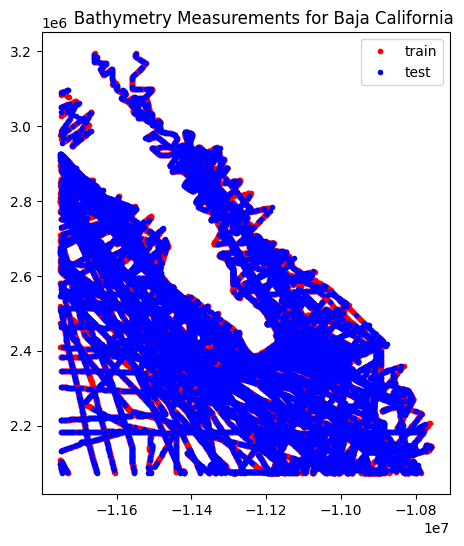

In [28]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.set_title("       Bathymetry Measurements for Baja California")
ax.plot(train[0][0], train[0][1], ".r", label="train")
ax.plot(test[0][0], test[0][1], ".b", label="test")
ax.legend()
ax.set_aspect("equal")
plt.show()

We can pass the training dataset to the :meth:`~verde.base.BaseGridder.fit` method of
most gridders using Python's argument expansion using the ``*`` symbol.



In [23]:
spline = vd.Spline()
spline.fit(*trainz)

Spline()

## Scoring

Verde implement the :meth:`~verde.base.BaseGridder.score` method that
calculates the `R² coefficient of determination
<https://en.wikipedia.org/wiki/Coefficient_of_determination>`__
for a given comparison dataset (``test`` in our case). The R² score is at most 1,
meaning a perfect prediction, but has no lower bound.



In [24]:
score = spline.score(*testz)
print("R² score:", score)

R² score: 0.8404555934110417


That's a good score meaning that our gridder is able to accurately predict data that
wasn't used in the gridding algorithm.

.. caution::

    Once caveat for this score is that it is highly dependent on the particular split
    that we made. Changing the random number generator seed in
    :func:`verde.train_test_split` will result in a different score.



In [25]:
# Use 1 as a seed instead of 0
train_other, test_other = vd.train_test_split(
    proj_coordz, dataz.air_temperature_c, test_size=0.3, random_state=1
)
print("R² score with seed 1:", vd.Spline().fit(*train_other).score(*test_other))

R² score with seed 1: 0.7832225533579885


## Cross-validation

A more robust way of scoring the gridders is to use function
:func:`verde.cross_val_score`, which (by default) uses a `k-fold cross-validation
<https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation>`__
by default. It will split the data *k* times and return the score on each *fold*. We
can then take a mean of these scores.



In [26]:
scores = vd.cross_val_score(vd.Spline(), proj_coordz, dataz.air_temperature_c)
print("k-fold scores:", scores)
print("Mean score:", np.mean(scores))

k-fold scores: [0.81656248 0.7201931  0.81596367 0.87740131 0.75006738]
Mean score: 0.7960375866932156


## Improving the score

That score is not bad but it could be better. The default arguments for
:class:`~verde.Spline` aren't optimal for this dataset. We could try
different combinations manually until we get a good score. A better way is to
do this automatically.

